In [8]:
from base_functions import *
pd.set_option('display.max_rows', 10)

In [9]:

#fdr.DataReader("US1YT=X", "2016-09-01", "2021-08-31")

<Figure size 800x1000 with 0 Axes>

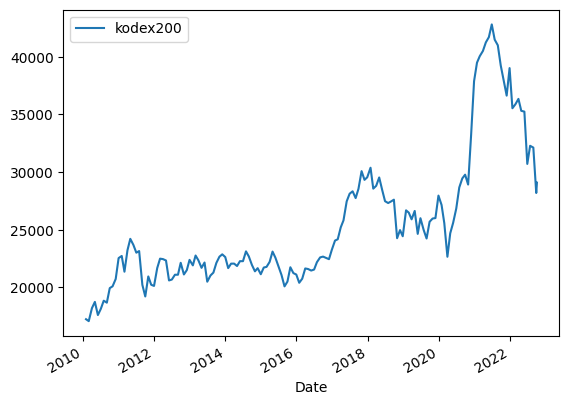

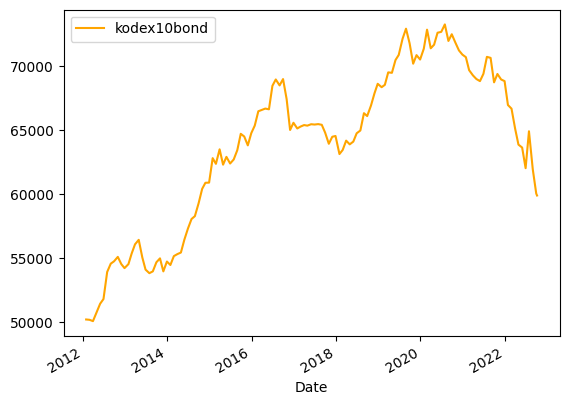

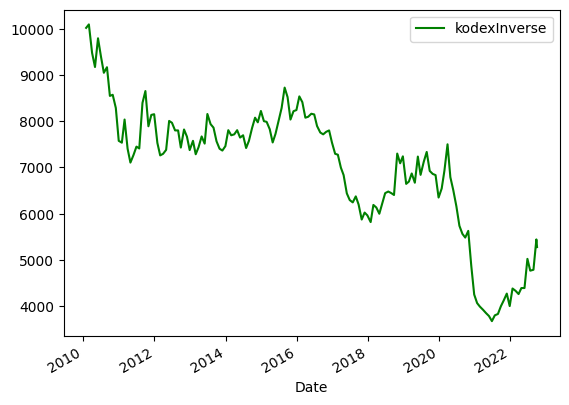

In [10]:
kodex200 = getCloseDataFdr("069500", "2010-01-10", "2022-10-10") # 코스피200 ETF
kodex10Bond = getCloseDataFdr("152380", "2010-01-10", "2022-10-10") # kodex 국고채 10년물 etf
kodexInverse = getCloseDataFdr("114800", "2010-01-10", "2022-10-10") # kodex inverse
kodex200_rebal = kodex200.loc[getRebalancingDate(kodex200)]
kodex10Bond_rebal = kodex10Bond.loc[getRebalancingDate(kodex10Bond)]
kodexInverse_rebal = kodexInverse.loc[getRebalancingDate(kodexInverse)]


plt.figure(figsize=(8, 10))
plt.subplots()
kodex200_rebal.plot(label="kodex200")
plt.legend()

plt.subplots()
kodex10Bond_rebal.plot(label="kodex10bond", color="orange")
plt.legend()


plt.subplots()
kodexInverse_rebal.plot(label="kodexInverse", color="green")
plt.legend()


In [11]:
closeData = pd.concat([kodex200, kodex10Bond, kodexInverse], axis=1)
closeData.columns = ["kodex200", "kodex10Bond", "kodexInverse"]
closeData.dropna(inplace=True)

closeDataMomentum = closeData.copy()
closeDataBase = closeData.copy()
closeData

,kodex200,kodex10Bond,kodexInverse
Date,,,
2012-01-20,21668,49960.0,7525
2012-01-25,21744,49960.0,7490
2012-01-26,21765,49930.0,7480
2012-01-27,21798,50000.0,7475
2012-01-30,21552,50130.0,7560
...,...,...,...
2022-09-30,28176,60035.0,5445
2022-10-04,28859,60815.0,5315
2022-10-05,28864,60495.0,5315


In [12]:
rebalDate = getRebalancingDate(closeData)
priceOnRebalDate = closeData.loc[rebalDate]
priceOnRebalDate

,kodex200,kodex10Bond,kodexInverse
Date,,,
2012-01-31,21668,50180.0,7530
2012-02-29,22476,50155.0,7260
2012-03-30,22437,50050.0,7295
2012-04-30,22316,50735.0,7380
2012-05-31,20585,51410.0,8005
...,...,...,...
2022-06-30,30700,62025.0,5025
2022-07-29,32272,64915.0,4770
2022-08-31,32117,61935.0,4790


In [13]:
def getWeightByAvgMomentumScoreWithInverse(closeDataSet, inverse=None,  n=12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """


    if inverse is not None:
        closeDataSet = closeDataSet.drop("kodexInverse", axis=1)
        
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    # 평균 모멘텀 스코어 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n

    avgMomentumScore["kodexInverse"] = np.where((avgMomentumScore["kodex200"] + avgMomentumScore["kodex10Bond"])/2 < 0.3, 1, 0)
    
    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)

    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
    
    # 투자비중, 평균 모멘텀 스코어 리턴
    return weight, avgMomentumScore


In [14]:
pd.set_option('display.max_rows', None)
weight, avgMomentumScore = getWeightByAvgMomentumScoreWithInverse(closeDataMomentum, inverse="kodexInverse")
avgMomentumScore["kodexInverse"] = np.where((avgMomentumScore["kodex200"] + avgMomentumScore["kodex10Bond"])/2 < 0.3, 1, 0)
print(weight, "\n\n", avgMomentumScore)
pd.set_option('display.max_rows', 10)

            kodex200  kodex10Bond  kodexInverse  cash
Date                                                 
2012-01-31  0.000000     0.000000      1.000000     0
2012-02-29  0.076923     0.000000      0.923077     0
2012-03-30  0.076923     0.000000      0.923077     0
2012-04-30  0.062500     0.187500      0.750000     0
2012-05-31  0.000000     0.250000      0.750000     0
2012-06-29  0.055556     0.277778      0.666667     0
2012-07-31  0.250000     0.750000      0.000000     0
2012-08-31  0.222222     0.777778      0.000000     0
2012-09-28  0.384615     0.615385      0.000000     0
2012-10-31  0.307692     0.692308      0.000000     0
2012-11-30  0.416667     0.583333      0.000000     0
2012-12-28  0.562500     0.437500      0.000000     0
2013-01-31  0.466667     0.533333      0.000000     0
2013-02-28  0.500000     0.500000      0.000000     0
2013-03-29  0.428571     0.571429      0.000000     0
2013-04-30  0.333333     0.666667      0.000000     0
2013-05-31  0.529412     0.4

In [15]:
def getRebalancingPortfolioWithInverse(
        closeDataSet,
        inverseDataSet=None,
        period="month",
        weightDf=None,
        rebalDate=None
):    
    #자산별 비중, 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period)
        
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)],
                                index=rebalancingDate,
                                columns=closeDataSet.columns)

    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        if rebalDate is None:
            rebalancingDate = getRebalancingDate(closeDataSet, period=period)
        else:
            rebalancingDate = rebalDate

    portfolio = pd.DataFrame()

    totalAsset = 1
    start = rebalancingDate[0]
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start]
        priceData = closeDataSet.loc[start:end]
        cumRet = getCumulativeReturn(priceData)
        weightCumRet = weight * cumRet
        netCumRet = totalAsset * weightCumRet

        
        print(f"weight:\n{weight}\n\ncumRet:\n{cumRet}\n\nnetCumRet:{netCumRet}")
        
        start = end
        totalAsset = netCumRet.iloc[-1].sum()
        portfolio = pd.concat([portfolio, netCumRet])

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep="last")]
    portfolioCumulativeReturn = portfolio.sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1))

    return portfolioDayReturn, portfolioCumulativeReturn


In [16]:
# base
dayRetBase, cumRetBase = getRebalancingPortfolioWithInverse(closeDataSet=closeDataBase, weightDf=None)
print(f"Base 최종수익률: {cumRetBase.iloc[-1]}")
base_cagr, base_dd, base_mdd = getEval(cumRetBase)

weight:
kodex200        0.333333
kodex10Bond     0.333333
kodexInverse    0.333333
Name: 2012-01-31 00:00:00, dtype: float64

cumRet:
            kodex200  kodex10Bond  kodexInverse
Date                                           
2012-01-31  1.000000     1.000000      1.000000
2012-02-01  1.001246     1.000996      0.997344
2012-02-02  1.012507     1.000000      0.984728
2012-02-03  1.007338     1.000199      0.991368
2012-02-06  1.008815     0.998804      0.990704
...              ...          ...           ...
2012-02-23  1.027368     0.996811      0.973440
2012-02-24  1.031706     0.996811      0.968792
2012-02-27  1.018045     0.998605      0.984064
2012-02-28  1.025891     0.999203      0.974768
2012-02-29  1.037290     0.999502      0.964143

[22 rows x 3 columns]

netCumRet:            kodex200  kodex10Bond  kodexInverse
Date                                           
2012-01-31  0.333333     0.333333      0.333333
2012-02-01  0.333749     0.333665      0.332448
2012-02-02  0.33

Base 최종수익률: 1.1348916860854603
return: 1.1348916860854603 
 cagr: 1.012188952430995 
 mdd: 8.253579571548768


In [17]:
# 12 month average momentum
closeDataMomentum["cash"] = 1
dayRetMomentum, cumRetMomentum = getRebalancingPortfolioWithInverse(closeDataSet=closeDataMomentum, weightDf=weight)
print(f"12개월 평균 모멘텀 스코어 최종수익률: {cumRetMomentum.iloc[-1]}")
momentum_cagr, momentum_dd, momentum_mdd = getEval(cumRetMomentum)

weight:
kodex200        0.0
kodex10Bond     0.0
kodexInverse    1.0
cash            0.0
Name: 2012-01-31 00:00:00, dtype: float64

cumRet:
            kodex200  kodex10Bond  kodexInverse  cash
Date                                                 
2012-01-31  1.000000     1.000000      1.000000   1.0
2012-02-01  1.001246     1.000996      0.997344   1.0
2012-02-02  1.012507     1.000000      0.984728   1.0
2012-02-03  1.007338     1.000199      0.991368   1.0
2012-02-06  1.008815     0.998804      0.990704   1.0
...              ...          ...           ...   ...
2012-02-23  1.027368     0.996811      0.973440   1.0
2012-02-24  1.031706     0.996811      0.968792   1.0
2012-02-27  1.018045     0.998605      0.984064   1.0
2012-02-28  1.025891     0.999203      0.974768   1.0
2012-02-29  1.037290     0.999502      0.964143   1.0

[22 rows x 4 columns]

netCumRet:            kodex200  kodex10Bond  kodexInverse  cash
Date                                                 
2012-01-31       

weight:
kodex200        0.521739
kodex10Bond     0.478261
kodexInverse    0.000000
cash            0.000000
Name: 2016-08-31 00:00:00, dtype: float64

cumRet:
            kodex200  kodex10Bond  kodexInverse  cash
Date                                                 
2016-08-31  1.000000     1.000000      1.000000   1.0
2016-09-01  0.997476     0.996205      1.001934   1.0
2016-09-02  0.999424     0.995840      0.999355   1.0
2016-09-05  1.012176     0.997591      0.988395   1.0
2016-09-06  1.015896     0.998321      0.984526   1.0
...              ...          ...           ...   ...
2016-09-26  1.003055     0.998905      0.995487   1.0
2016-09-27  1.010051     0.999124      0.987750   1.0
2016-09-28  1.007040     1.000949      0.991618   1.0
2016-09-29  1.014213     1.001387      0.983237   1.0
2016-09-30  1.003055     1.007226      0.994842   1.0

[20 rows x 4 columns]

netCumRet:            kodex200  kodex10Bond  kodexInverse  cash
Date                                               


weight:
kodex200        0.5
kodex10Bond     0.5
kodexInverse    0.0
cash            0.0
Name: 2016-09-30 00:00:00, dtype: float64

cumRet:
            kodex200  kodex10Bond  kodexInverse  cash
Date                                                 
2016-09-30  1.000000     1.000000      1.000000   1.0
2016-10-04  1.006003     0.995217      0.993519   1.0
2016-10-05  1.005430     0.990652      0.994167   1.0
2016-10-06  1.012360     0.988406      0.988983   1.0
2016-10-07  1.009270     0.989203      0.991575   1.0
...              ...          ...           ...   ...
2016-10-25  1.003973     0.980362      0.998056   1.0
2016-10-26  0.991790     0.982101      1.009721   1.0
2016-10-27  0.996160     0.978333      1.004537   1.0
2016-10-28  0.996778     0.973768      1.003889   1.0
2016-10-31  0.994835     0.977246      1.007129   1.0

[21 rows x 4 columns]

netCumRet:            kodex200  kodex10Bond  kodexInverse  cash
Date                                                 
2016-09-30  0.54

weight:
kodex200        0.214286
kodex10Bond     0.785714
kodexInverse    0.000000
cash            0.000000
Name: 2019-01-31 00:00:00, dtype: float64

cumRet:
            kodex200  kodex10Bond  kodexInverse  cash
Date                                                 
2019-01-31  1.000000     1.000000      1.000000   1.0
2019-02-01  0.998950     1.001828      1.003010   1.0
2019-02-07  0.998950     1.001170      1.001505   1.0
2019-02-08  0.984852     1.003584      1.015801   1.0
2019-02-11  0.986539     1.005778      1.014296   1.0
...              ...          ...           ...   ...
2019-02-22  1.007987     1.000951      0.991723   1.0
2019-02-25  1.010049     1.000731      0.990218   1.0
2019-02-26  1.006224     1.000951      0.993228   1.0
2019-02-27  1.009486     1.002560      0.990218   1.0
2019-02-28  0.992463     1.002706      1.007524   1.0

[18 rows x 4 columns]

netCumRet:            kodex200  kodex10Bond  kodexInverse  cash
Date                                               

weight:
kodex200        1.0
kodex10Bond     0.0
kodexInverse    0.0
cash            0.0
Name: 2021-04-30 00:00:00, dtype: float64

cumRet:
            kodex200  kodex10Bond  kodexInverse  cash
Date                                                 
2021-04-30  1.000000     1.000000      1.000000   1.0
2021-05-03  0.993600     0.999783      1.005188   1.0
2021-05-04  1.002012     1.000290      0.997406   1.0
2021-05-06  1.007904     1.002464      0.992218   1.0
2021-05-07  1.014425     1.000507      0.983139   1.0
...              ...          ...           ...   ...
2021-05-25  1.004752     1.001667      0.990921   1.0
2021-05-26  1.002740     1.001667      0.992218   1.0
2021-05-27  1.000946     1.002898      0.993515   1.0
2021-05-28  1.007104     1.000797      0.985733   1.0
2021-05-31  1.011007     0.997609      0.983139   1.0

[20 rows x 4 columns]

netCumRet:            kodex200  kodex10Bond  kodexInverse  cash
Date                                                 
2021-04-30  1.757

12개월 평균 모멘텀 스코어 최종수익률: 2.0582772945602485
return: 2.0582772945602485 
 cagr: 1.0715595945646397 
 mdd: 15.021097529157606


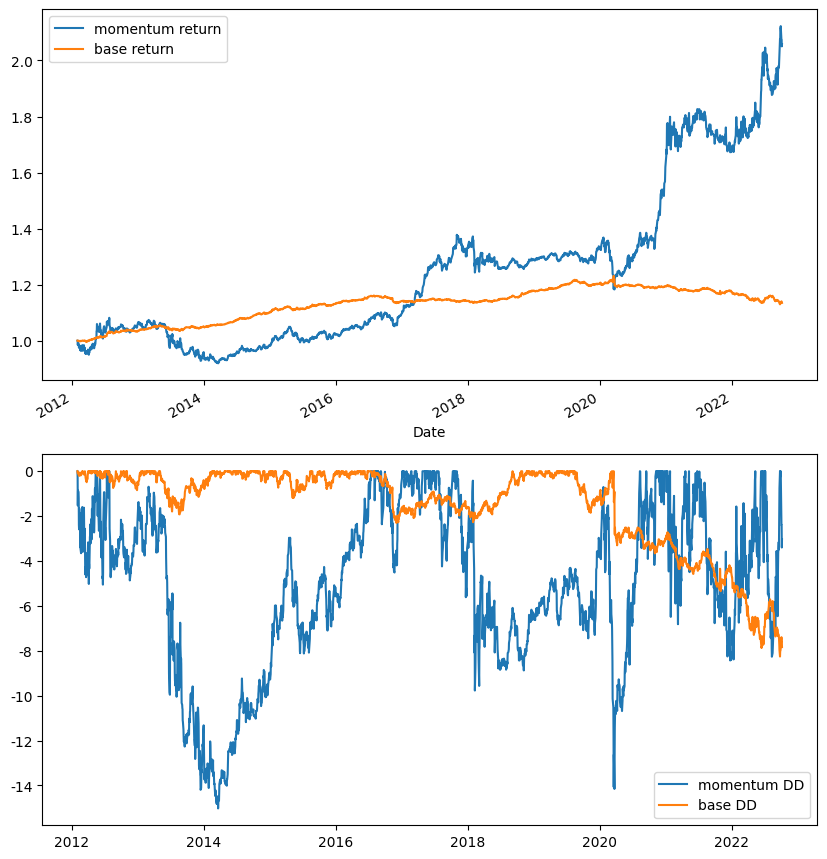

In [18]:
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,12))

# 수익곡선
plt.subplot(2,1,1)
cumRetMomentum.plot(label="momentum return")
cumRetBase.plot(label="base return")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-momentum_dd, label="momentum DD")
plt.plot(-base_dd, label="base DD")
plt.legend()

plt.show()
